In [70]:
# HIDDEN
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

**Some functions for plotting.**
- You don't have to understand how any of the functions in this cell work, since they use things we haven't learned about in Data 8.

In [71]:
# Some functions for plotting. You don't have to understand how any
# of the functions in this cell work, since they use things we 
# haven't learned about in Data 8.

def resize_window(lim=3.5):
    plots.xlim(-lim, lim)
    plots.ylim(-lim, lim)
    
def draw_line(slope=0, intercept=0, x=make_array(-4, 4), color='r'):
    y = x*slope + intercept
    plots.plot(x, y, color=color)
    
def draw_vertical_line(x_position, color='black'):
    x = make_array(x_position, x_position)
    y = make_array(-4, 4)
    plots.plot(x, y, color=color)
    
def make_correlated_data(r):
    x = np.random.normal(0, 1, 1000)
    z = np.random.normal(0, 1, 1000)
    y = r*x + (np.sqrt(1-r**2))*z
    return x, y

def r_table(r):
    """
    Generate a table of 1000 x,y data points in standard units
    whose correlation is approximately equal to r
    """
    np.random.seed(8)
    x, y = make_correlated_data(r)
    return Table().with_columns('x', x, 'y', y)

And you especially don't need to worry about these two here!

In [72]:
def demographics_errors(slope, intercept):
    # Use four convenient points from the original data
    sample = [[14.7, 33995], [19.1, 61454], [50.7, 71183], [59.5, 105918]]
    demographics.scatter('College%', 'Median Income', alpha=0.5)
    xlims = make_array(5, 75)
    # Plot a line with the slope and intercept you specified:
    plots.plot(xlims, slope * xlims + intercept, lw=4)
    # Plot red lines from each of the four points to the line
    for x, y in sample:
        plots.plot([x, x], [y, slope * x + intercept], color='r', lw=4)

In [73]:
def show_demographics_rmse(slope, intercept):
    demographics_errors(slope, intercept)
    x = demographics.column('College%')
    y = demographics.column('Median Income')
    prediction = slope * x + intercept
    mse = np.mean((y - prediction) ** 2)
    print("Root mean squared error:", round(mse ** 0.5, 2))

# Lecture 24

### Functions from last time 

**Standard units, correlation coefficient**

In [74]:
def standard_units(x):
    """Converts an array x to standard units"""
    return (x - np.mean(x)) / np.std(x)

def correlation(t, x, y):
    x_su = standard_units(t.column(x))
    y_su = standard_units(t.column(y))
    return np.mean(x_su * y_su)

**Slope and intercept**

In [3]:
def slope(t, x, y):
    """Computes the slope of the regression line"""
    r = correlation(t, x, y)
    y_sd = np.std(t.column(y))
    x_sd = np.std(t.column(x))
    return r * y_sd / x_sd

def intercept(t, x, y):
    """Computes the intercept of the regression line"""
    x_mean = np.mean(t.column(x))
    y_mean = np.mean(t.column(y))
    return y_mean - slope(t, x, y)*x_mean

### Error in Estimation

**The dataset and the relationship between $x$ and $y$**

In [4]:
demographics = Table.read_table('district_demographics2016.csv')
demographics.show(5)

State,District,Median Income,Percent voting for Clinton,College%
Alabama,"Congressional District 1 (115th Congress), Alabama",47083,34.1,24
Alabama,"Congressional District 2 (115th Congress), Alabama",42035,33,21.8
Alabama,"Congressional District 3 (115th Congress), Alabama",46544,32.3,22.8
Alabama,"Congressional District 4 (115th Congress), Alabama",41110,17.4,17
Alabama,"Congressional District 5 (115th Congress), Alabama",51690,31.3,30.3


In [5]:
demographics = demographics.drop(
    'State', 'District', 'Percent voting for Clinton')
demographics.show(5)

Median Income,College%
47083,24
42035,21.8
46544,22.8
41110,17
51690,30.3


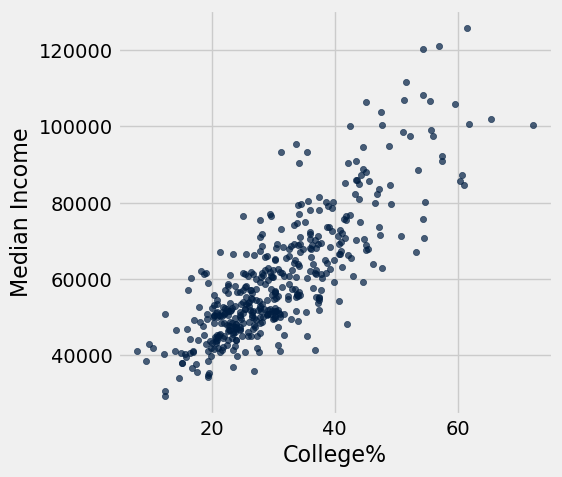

In [6]:
demographics.scatter('College%', 'Median Income')

In [7]:
correlation(demographics, 'College%', 'Median Income')

0.81846485171413352

In [8]:
regression_slope = slope(demographics, 'College%', 'Median Income')
regression_intercept = intercept(demographics, 'College%', 'Median Income')
regression_slope, regression_intercept

(1270.70168946388, 20802.577766677925)

**Finding the error in our estiamtion**

In [75]:
def fitted_values(t, x, y):
    """Return an array of the regressions estimates at all the x values"""
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a*t.column(x) + b

In [76]:
predicted = fitted_values(demographics, 'College%', 'Median Income')
predicted[1:6]

array([ 48503.87459699,  49774.57628645,  42404.50648756,  59304.83895743,
        67437.32977   ])

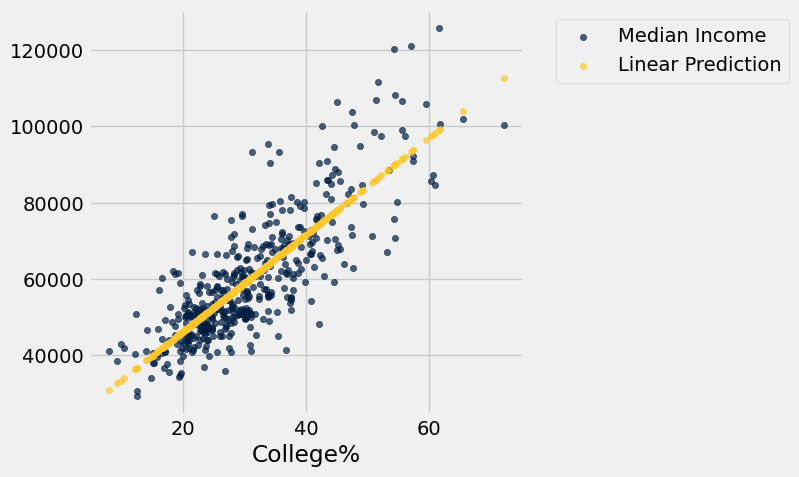

In [77]:
demographics = demographics.with_column(
    'Linear Prediction', predicted)
demographics.scatter('College%')

$$\text{Error} = \text{Actual} - \text{Predicted}$$

In [78]:
actual = demographics.column('Median Income')
errors = actual - predicted

In [27]:
demographics.with_column('Error', errors).show(6)

Median Income,College%,Linear Prediction,Error
47083,24,51299.4,-4216.42
42035,21.8,48503.9,-6468.87
46544,22.8,49774.6,-3230.58
41110,17,42404.5,-1294.51
51690,30.3,59304.8,-7614.84
61413,36.7,67437.3,-6024.33


**Mean Square Error** and **Root Mean Square Error** (RMSE)

In [79]:
np.mean(errors ** 2)

88332095.268617392

In [80]:
np.mean(errors ** 2) ** 0.5

9398.5155885712811

***Visualizing our error***

Root mean squared error: 11559.09


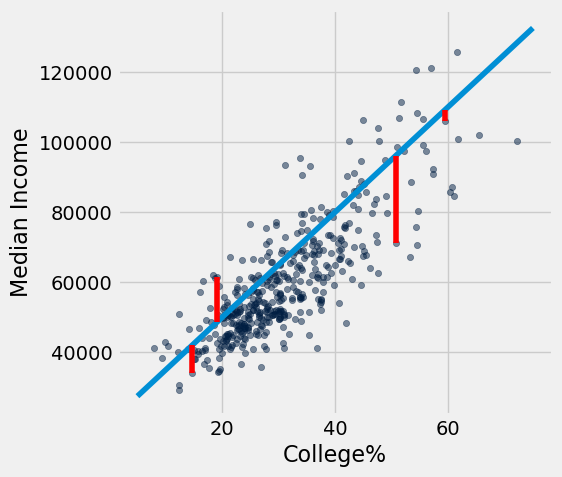

In [82]:
show_demographics_rmse(1500, 20000)

Root mean squared error: 30247.88


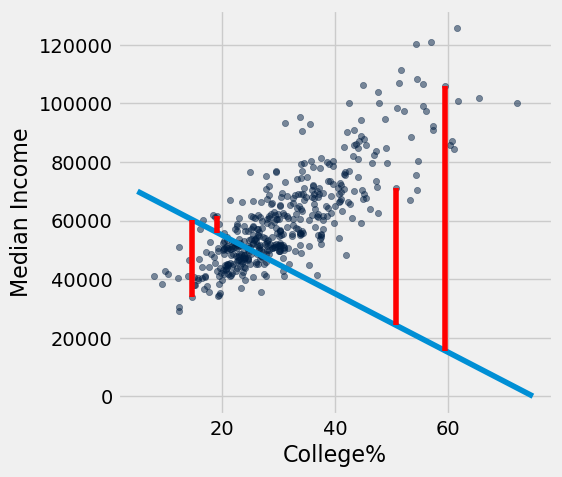

In [37]:
show_demographics_rmse(-1000, 75000)

Root mean squared error: 9398.52


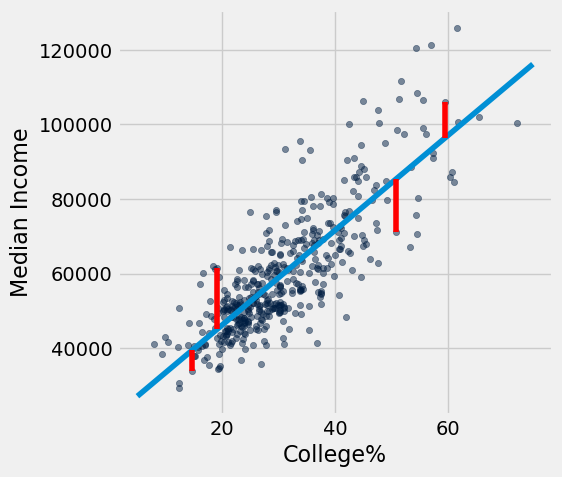

In [39]:
show_demographics_rmse(regression_slope, regression_intercept)

### Numerical Optimization (in a general setting) ###

Let's look at a nonlinear function

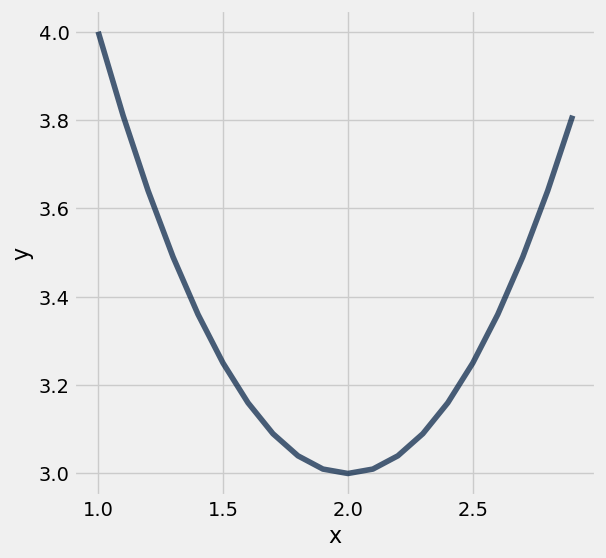

In [83]:
x = np.arange(1, 3, 0.1)
y = (x-2)**2 + 3
Table().with_columns('x', x, 'y', y).plot('x')

In [84]:
def f(x):
    return ((x-2)**2) + 3

Using the `minimize` function:
- Takes the function we are interested in minimzing as its argument

In [85]:
minimize(f)

1.9999999946252267

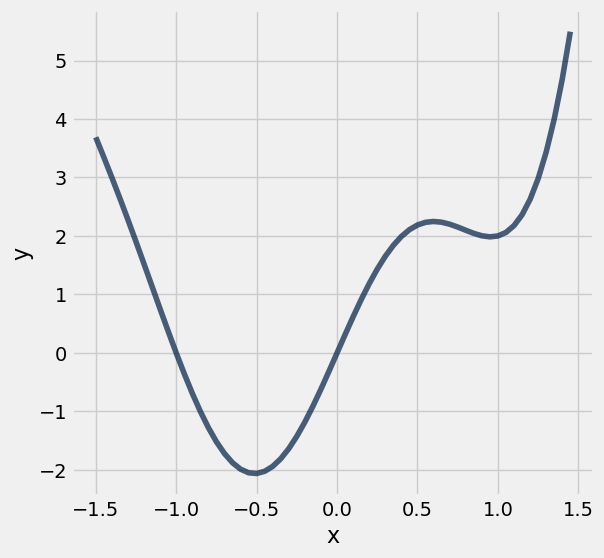

In [45]:
x = np.arange(-1.5, 1.5, 0.05)
y2 = 2 * np.sin(x*np.pi) + x ** 3 + x ** 4 
Table().with_columns('x', x, 'y', y2).plot('x')

In [87]:
def complicated_function(x):
    return 2 * np.sin(x*np.pi) + x ** 3 + x ** 4 

In [88]:
minimize(complicated_function)

-0.5126437620940081

### Minimizing RMSE (Numerical optimization for regression) ###

In [89]:
def demographics_rmse(any_slope, any_intercept):
    x = demographics.column('College%')
    y = demographics.column('Median Income')
    estimate = any_slope*x + any_intercept
    return (np.mean((y - estimate) ** 2)) ** 0.5

In [90]:
demographics_rmse(1500, 20000)

11559.086490075999

In [91]:
demographics_rmse(-1000, 75000)

30247.883767944502

Empirical proof that the regression line is the "best linear predictor":

In [52]:
make_array(regression_slope, regression_intercept)

array([  1270.70168946,  20802.57776668])

In [51]:
minimize(demographics_rmse)

array([  1270.70168805,  20802.57933807])

Note that the output is an array. 
- Why? Because we are trying to find the best value of `any_slope` and `any_intercept` as defined in the `demographics_rmse()` function.

In [69]:
# MSE

#### Nonlinear Regression

In [92]:
shotput = Table.read_table('shotput.csv')
shotput.show(6)

Weight Lifted,Shot Put Distance
37.5,6.4
51.5,10.2
61.3,12.4
61.3,13
63.6,13.2
66.1,13


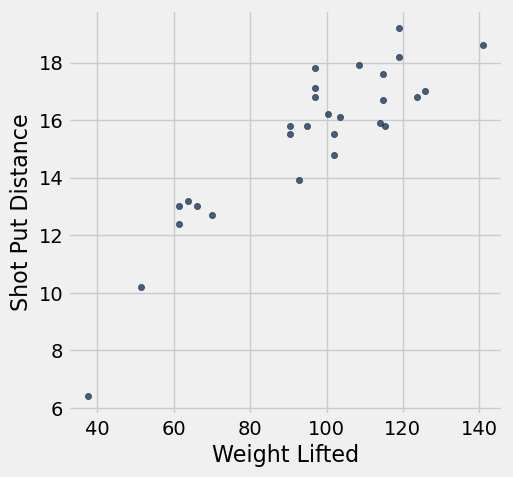

In [55]:
shotput.scatter('Weight Lifted')

**Linear fit**

$$
f(x) ~=~ ax + b 
$$

for constants $a$ and $b$.


The best $a$ and $b$ are given by the slope of the regression line. This means that we can also use `minimize()` to find this $a$ and $b$.

In [93]:
def shotput_linear_rmse(any_slope, any_intercept):
    x = shotput.column('Weight Lifted')
    y = shotput.column('Shot Put Distance')
    estimate = any_slope*x + any_intercept
    return np.mean((y - estimate) ** 2) ** 0.5

In [94]:
best_line = minimize(shotput_linear_rmse)
best_line

array([ 0.09834382,  5.95962883])

Fitting the line

In [95]:
weights = shotput.column(0)

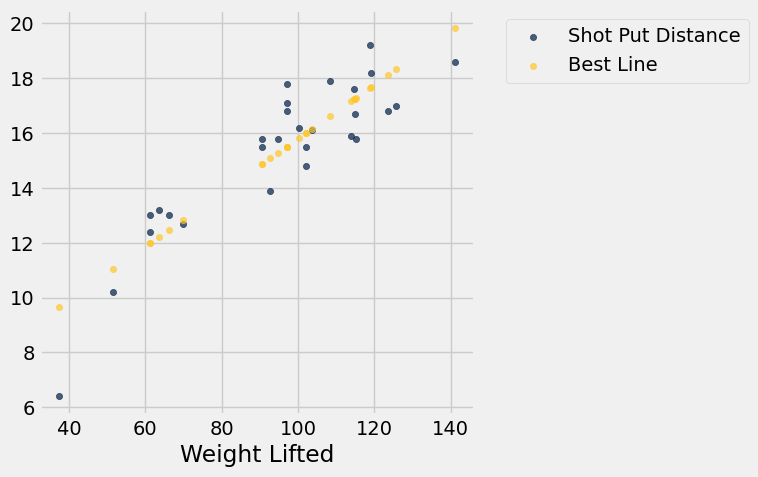

In [96]:
linear_fit = best_line.item(0)*weights + best_line.item(1)

shotput.with_column(
    'Best Line', linear_fit
).scatter(0)

**Quadratic Function**

$$
f(x) ~=~ ax^2 + bx + c
$$
for constants $a$, $b$, and $c$.

We can use `minimize()` here.

In [97]:
def shotput_quadratic_rmse(a, b, c):
    x = shotput.column('Weight Lifted')
    y = shotput.column('Shot Put Distance')
    estimate = a*(x**2) + b*x + c
    return np.mean((y - estimate) ** 2) ** 0.5

In [98]:
best_quad = minimize(shotput_quadratic_rmse)
best_quad

array([ -1.04003731e-03,   2.82706003e-01,  -1.53167618e+00])

In [66]:
# x = weight lifted = 100 kg
# Then predicted shot put distance:

(-0.00104)*(100**2) + 0.2827*100 - 1.5318

16.3382

In [67]:
quad_fit = best_quad.item(0)*(weights**2) + best_quad.item(1)*weights + best_quad.item(2)

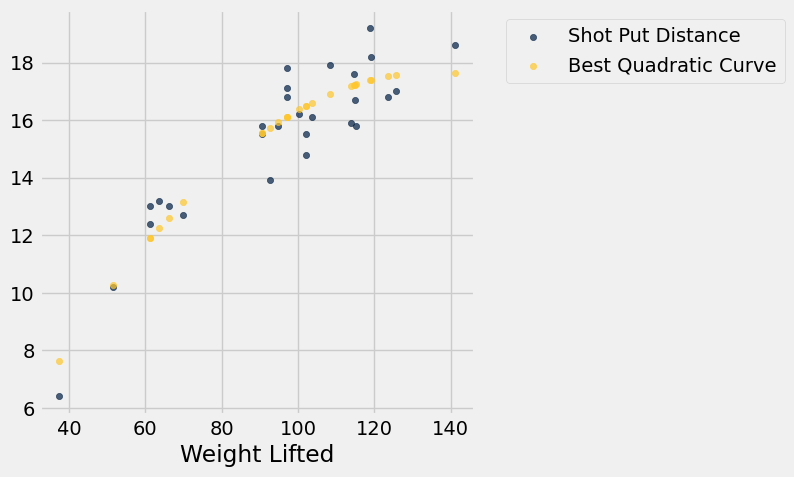

In [68]:
shotput.with_column('Best Quadratic Curve', quad_fit).scatter(0)